# Objectives

1. Add Locus Coverage to Dataframe.
1. Plot Locus Coverage: Distribution.
1. Plot Locus Coverage: Phlyo.
1. Identify Interesting Samples.

---
# Setup

## Imports

In [1]:
import os
import dill
from Bio import Phylo
import copy
import math
import pandas as pd
from matplotlib import lines, patches
import seaborn as sns

## File Paths

In [2]:
# jupyter notebook output
tree_df_dill = "../../results/mugration/mugration.df.obj"
tree_dill = "../../results/mugration/mugration.treetime.obj"
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"
locus_df_path = "../../results/locus_coverage/all/locus_coverage.txt"

# Auspice
auspice_latlon_path = "../../results/parse_tree/parse_tree_latlon.tsv"
auspice_colors_path = "../../results/parse_tree/parse_tree_colors.tsv"
auspice_config_path = "../../config/auspice_config.json"
auspice_remote_dir_path = "../../auspice/"

# Output
outdir = "../../results/locus_coverage/all/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [3]:
from config import *

#NAME_COL = "Sample"
NAME_COL = "Name"
SCRIPT_NAME = "locus_coverage"

## Import Tree

In [4]:
with open(tree_dill, "rb") as infile:
    tt = dill.load(infile)
tt.tree.ladderize(reverse=False)

## Import Dataframe

In [5]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad,Mugration_Branch_Number,Mugration_Branch_Number_Confidence,Mugration_Branch_Number_Entropy,Mugration_Branch_Major,Mugration_Branch_Major_Confidence,Mugration_Branch_Major_Entropy,Mugration_Branch_Minor,Mugration_Branch_Minor_Confidence,Mugration_Branch_Minor_Entropy,Mugration_Country,Mugration_Country_Confidence,Mugration_Country_Entropy,Mugration_Country_Lat,Mugration_Country_Lon,Mugration_Province,Mugration_Province_Confidence,Mugration_Province_Entropy,Mugration_Province_Lat,Mugration_Province_Lon
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0,black,2.14881e-07,16.1893,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,2.148815e-07,-4000-09-21,-3999.277481,"[-4114.0959399021, -3791.54718956593]","[6135.0959399021, 5812.54718956593]",0.100000,0.100000,16.189335,-3999.277481,0.000000,False,0,1,8.55565e-08,0.PRE,0.998731,0.00977069,0.PRE2,0.392436,1.32907,Russia,0.99242,0.0484304,64.6863,97.7453,Krasnoyarsk Krai,0.382138,1.65207,63.3234,97.098
SAMEA3541827,NA,NA,3.8504e-06,grey,3.43983e-06,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,2.800384e-09,0.302301,3.224947e-06,-2881-08-02,-2880.414384,"[-2875.9999999999995, -2676.9999999999995]","[4897.0, 4698.0]",1118.863097,1118.963097,1.000000,-2776.500000,0.000003,False,0,1,-1.00009e-12,0.PRE,1,-9.99867e-13,0.PRE2,1,-1.00009e-12,Russia,1,-1.00009e-12,64.6863,97.7453,Krasnoyarsk Krai,1,-1.00009e-12,63.3234,97.098
NODE1,100,85,1.32708e-05,black,8.39127e-06,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.185209e-08,1.279433,8.176386e-06,-3356-01-28,-3355.925187,"[-3424.5669580911117, -3154.7902001929688]","[5445.566958091112, 5175.790200192969]",643.352294,643.452294,3.156250,-3355.925187,0.000008,False,0,1,8.55565e-08,0.PRE,0.999998,2.33079e-05,0.PRE1,0.999213,0.00727438,Russia,0.977706,0.136133,64.6863,97.7453,Panevezys County,0.442487,1.9261,55.9156,25.0312
SAMEA104233046,NA,NA,2.2484e-06,grey,1.05415e-05,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,2.591999e-09,0.279806,2.150201e-06,-2617-08-21,-2616.363588,"[-2620.9999999999995, -2471.9999999999995]","[4642.0, 4493.0]",739.561600,1383.013893,2.000000,-2546.500000,0.000010,False,0,1,-1.00009e-12,0.PRE,1,-1.00009e-12,0.PRE1,1,-1.00009e-12,Lithuania,1,-1.00009e-12,55.35,23.75,Panevezys County,1,-1.00009e-12,55.9156,25.0312
NODE2,100,94.6,1.36364e-05,black,2.28244e-05,4.3125,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.987130e-08,2.145105,1.443313e-05,-2652-12-16,-2651.043091,"[-2740.0327670266406, -2561.2954874168845]","[4761.032767026641, 4582.2954874168845]",704.882097,1348.334390,4.312500,-2651.043091,0.000023,False,0,1,8.55565e-08,0.PRE,1,2.10548e-07,0.PRE1,0.999999,1.69062e-05,Russia,0.97708,0.14249,64.6863,97.7453,Pärnu maakond,0.442563,1.92163,58.3195,24.3026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE_0000360,NA,NA,NA,NA,6.56282e-05,541.5,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.949873e-09,0.966138,1.779610e-21,1953-12-09,1953.939572,"[1926.3366503317973, 1954.0]","[94.66334966820273, 67.0]",1.314338,5953.317053,541.500000,1953.939572,0.000065,False,1,1,8.35157e-08,1.ORI,1,2.02107e-07,1.ORI1,1,9.61593e-07,United States 

## Import Locus Dataframe

In [6]:
# Parse the metadata
locus_df = pd.read_csv(locus_df_path, sep='\t')
locus_df.drop(columns=["pla_cov"], inplace=True)
locus_df_samples = locus_df.index

# Remove samples not in tree dataframe
for sample in locus_df_samples:
    if sample not in tree_df.index:
        locus_df.drop(sample, inplace=True)

locus_df.columns = ["Chrom_cov", "pCD1_cov", "pMT1_cov", "pPCP1_cov", "pla_cov",
                     "Chrom_dep", "pCD1_dep", "pMT1_dep", "pPCP1_dep", "pla_dep"]
locus_cov_df = locus_df.drop(columns=["Chrom_dep", "pCD1_dep", "pMT1_dep", "pPCP1_dep", "pla_dep"])

locus_dep_df = locus_df.drop(columns=["Chrom_cov", "pCD1_cov", "pMT1_cov", "pPCP1_cov", "pla_cov"])

display(locus_cov_df)
display(locus_dep_df)

,Chrom_cov,pCD1_cov,pMT1_cov,pPCP1_cov,pla_cov
GCA_009909635.1_ASM990963v1_genomic,0.919553,0.919181,0.938385,0.000000,0.000000
GCA_009669545.1_ASM966954v1_genomic,0.947885,0.941384,0.941461,0.800666,1.000000
GCA_009669555.1_ASM966955v1_genomic,0.945635,0.931143,0.940838,0.800250,1.000000
GCA_009669565.1_ASM966956v1_genomic,0.947141,0.938070,0.939892,0.800458,1.000000
GCA_009669605.1_ASM966960v1_genomic,0.948884,0.948012,0.941908,0.802122,1.000000
...,...,...,...,...,...
IP283,0.932657,0.938767,0.946918,0.811174,1.000000
IP562,0.927028,0.951042,0.012442,0.115273,0.133262
IP542,0.883070,0.951269,0.647459,0.812734,1.000000
IP543,0.882816,0.950174,0.615186,0.809717,1.000000


,Chrom_dep,pCD1_dep,pMT1_dep,pPCP1_dep,pla_dep
GCA_009909635.1_ASM990963v1_genomic,18.131132,17.534016,18.537262,0.000000,0.000000
GCA_009669545.1_ASM966954v1_genomic,18.714769,18.298443,18.576500,15.645235,20.000000
GCA_009669555.1_ASM966955v1_genomic,18.661659,18.042614,18.605852,15.647004,20.000000
GCA_009669565.1_ASM966956v1_genomic,18.693686,18.177357,18.416027,15.645756,20.000000
GCA_009669605.1_ASM966960v1_genomic,18.731531,18.413654,18.628365,15.691635,20.000000
...,...,...,...,...,...
IP283,39.573673,17.378010,47.722679,94.689239,132.750534
IP562,41.564549,47.482655,0.012442,0.115273,0.133262
IP542,41.832504,52.519962,33.234039,118.605286,162.257996
IP543,35.658241,47.615475,25.208118,101.258530,142.840088


## Import Colors

In [7]:
colors_df = pd.read_csv(auspice_colors_path, sep='\t', header=None)
colors_df.columns = ["Attribute", "State", "Color"]
colors_df.fillna(NO_DATA_CHAR, inplace=True)
colors_df

,Attribute,State,Color
0,branch_number,0,#8000ff
1,branch_number,3,#00b4ec
2,branch_number,4,#80ffb4
3,branch_number,2,#ffb462
4,branch_number,1,#ff0000
...,...,...,...
202,province,Midlands,#ff1c0e
203,province,State of Mato Grosso,#ff150b
204,province,MSila,#ff0e07
205,province,La Paz,#ff0704


---
# 1. Add Locus Info to Dataframe

In [8]:
for locus in locus_df.columns:
    tree_df[locus] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
    for i in range(0, len(locus_df[locus])):
        sample = locus_df.index[i]
        if sample not in tree_df.index: continue
        cov = locus_df[locus][i]
        tree_df.at[sample, locus] = cov

display(tree_df)


,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad,Mugration_Branch_Number,Mugration_Branch_Number_Confidence,Mugration_Branch_Number_Entropy,Mugration_Branch_Major,Mugration_Branch_Major_Confidence,Mugration_Branch_Major_Entropy,Mugration_Branch_Minor,Mugration_Branch_Minor_Confidence,Mugration_Branch_Minor_Entropy,Mugration_Country,Mugration_Country_Confidence,Mugration_Country_Entropy,Mugration_Country_Lat,Mugration_Country_Lon,Mugration_Province,Mugration_Province_Confidence,Mugration_Province_Entropy,Mugration_Province_Lat,Mugration_Province_Lon,Chrom_cov,pCD1_cov,pMT1_cov,pPCP1_cov,pla_cov,Chrom_dep,pCD1_dep,pMT1_dep,pPCP1_dep,pla_dep
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0,black,2.14881e-07,16.1893,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,2.148815e-07,-4000-09-21,-3999.277481,"[-4114.0959399021, -3791.54718956593]","[6135.0959399021, 5812.54718956593]",0.100000,0.100000,16.189335,-3999.277481,0.000000,False,0,1,8.55565e-08,0.PRE,0.998731,0.00977069,0.PRE2,0.392436,1.32907,Russia,0.99242,0.0484304,64.6863,97.7453,Krasnoyarsk Krai,0.382138,1.65207,63.3234,97.098,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.8504e-06,grey,3.43983e-06,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,2.800384e-09,0.302301,3.224947e-06,-2881-08-02,-2880.414384,"[-2875.9999999999995, -2676.9999999999995]","[4897.0, 4698.0]",1118.863097,1118.963097,1.000000,-2776.500000,0.000003,False,0,1,-1.00009e-12,0.PRE,1,-9.99867e-13,0.PRE2,1,-1.00009e-12,Russia,1,-1.00009e-12,64.6863,97.7453,Krasnoyarsk Krai,1,-1.00009e-12,63.3234,97.098,0.945769,0.926392,0.725216,0.797233,1,19.494,32.7473,11.4042,20.5553,19.8166
NODE1,100,85,1.32708e-05,black,8.39127e-06,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.185209e-08,1.279433,8.176386e-06,-3356-01-28,-3355.925187,"[-3424.5669580911117, -3154.7902001929688]","[5445.566958091112, 5175.790200192969]",643.352294,643.452294,3.156250,-3355.925187,0.000008,False,0,1,8.55565e-08,0.PRE,0.999998,2.33079e-05,0.PRE1,0.999213,0.00727438,Russia,0.977706,0.136133,64.6863,97.7453,Panevezys County,0.442487,1.9261,55.9156,25.0312,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.2484e-06,grey,1.05415e-05,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,2.591999e-09,0.279806,2.150201e-06,-2617-08-21,-2616.363588,"[-2620.9999999999995, -2471.9999999999995]","[4642.0, 4493.0]",739.561600,1383.013893,2.000000,-2546.500000,0.000010,False,0,1,-1.00009e-12,0.PRE,1,-1.00009e-12,0.PRE1,1,-1.00009e-12,Lithuania,1,-1.00009e-12,55.35,23.75,Panevezys County,1,-1.00009e-12,55.9156,25.0312,0.939948,0.933461,0.725195,0.803059,1,5.03738,9.93292,4.67118,19.5298,23.4222
NODE2,100,94.6,1.36364e-05,black,2.28244e-05,4.3125,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.987130e-08,2.145105,1.443313e-05,-2652-12-16,-2651.043091,"[-2740.0327670266406, -2561.2954874168845]","[4761.032767026641, 4582.2954874168845]",704.882097,1348.334390,4.312500,-2651.043091,0.000023,False,0,1,8.55565e-08,0.PRE,1,2.10548e-07,0.PRE1,0.999999,1.69062e-05,Russia,0.97708,0.14249,64.6863,97.7453,Pärnu maakond,0.442563,1.92163,58.3195,24.3026,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [9]:
# add ratios
locus = ["pPCP1"]
gene = ["pla"]

for l,g in zip(locus, gene):
    ratio_col = l + "_" + g + "_dep_ratio"
    tree_df[ratio_col] = [NO_DATA_CHAR for row in range(0,len(tree_df))]
    ratio_df = locus_df[[l + "_dep", g + "_dep"]]
    for rec in ratio_df.iterrows():
        sample = rec[0]
        l_dep = rec[1][l + "_dep"]
        g_dep = rec[1][g + "_dep"]
        if l_dep == 0 or g_dep == 0 or l_dep < 10:
            ratio = NO_DATA_CHAR
        else:
            ratio = l_dep / g_dep
        tree_df.at[sample,ratio_col] = ratio
        
display(tree_df)

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad,Mugration_Branch_Number,Mugration_Branch_Number_Confidence,Mugration_Branch_Number_Entropy,Mugration_Branch_Major,Mugration_Branch_Major_Confidence,Mugration_Branch_Major_Entropy,Mugration_Branch_Minor,Mugration_Branch_Minor_Confidence,Mugration_Branch_Minor_Entropy,Mugration_Country,Mugration_Country_Confidence,Mugration_Country_Entropy,Mugration_Country_Lat,Mugration_Country_Lon,Mugration_Province,Mugration_Province_Confidence,Mugration_Province_Entropy,Mugration_Province_Lat,Mugration_Province_Lon,Chrom_cov,pCD1_cov,pMT1_cov,pPCP1_cov,pla_cov,Chrom_dep,pCD1_dep,pMT1_dep,pPCP1_dep,pla_dep,pPCP1_pla_dep_ratio
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0,black,2.14881e-07,16.1893,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,2.148815e-07,-4000-09-21,-3999.277481,"[-4114.0959399021, -3791.54718956593]","[6135.0959399021, 5812.54718956593]",0.100000,0.100000,16.189335,-3999.277481,0.000000,False,0,1,8.55565e-08,0.PRE,0.998731,0.00977069,0.PRE2,0.392436,1.32907,Russia,0.99242,0.0484304,64.6863,97.7453,Krasnoyarsk Krai,0.382138,1.65207,63.3234,97.098,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.8504e-06,grey,3.43983e-06,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,2.800384e-09,0.302301,3.224947e-06,-2881-08-02,-2880.414384,"[-2875.9999999999995, -2676.9999999999995]","[4897.0, 4698.0]",1118.863097,1118.963097,1.000000,-2776.500000,0.000003,False,0,1,-1.00009e-12,0.PRE,1,-9.99867e-13,0.PRE2,1,-1.00009e-12,Russia,1,-1.00009e-12,64.6863,97.7453,Krasnoyarsk Krai,1,-1.00009e-12,63.3234,97.098,0.945769,0.926392,0.725216,0.797233,1,19.494,32.7473,11.4042,20.5553,19.8166,1.03728
NODE1,100,85,1.32708e-05,black,8.39127e-06,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.185209e-08,1.279433,8.176386e-06,-3356-01-28,-3355.925187,"[-3424.5669580911117, -3154.7902001929688]","[5445.566958091112, 5175.790200192969]",643.352294,643.452294,3.156250,-3355.925187,0.000008,False,0,1,8.55565e-08,0.PRE,0.999998,2.33079e-05,0.PRE1,0.999213,0.00727438,Russia,0.977706,0.136133,64.6863,97.7453,Panevezys County,0.442487,1.9261,55.9156,25.0312,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.2484e-06,grey,1.05415e-05,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,2.591999e-09,0.279806,2.150201e-06,-2617-08-21,-2616.363588,"[-2620.9999999999995, -2471.9999999999995]","[4642.0, 4493.0]",739.561600,1383.013893,2.000000,-2546.500000,0.000010,False,0,1,-1.00009e-12,0.PRE,1,-1.00009e-12,0.PRE1,1,-1.00009e-12,Lithuania,1,-1.00009e-12,55.35,23.75,Panevezys County,1,-1.00009e-12,55.9156,25.0312,0.939948,0.933461,0.725195,0.803059,1,5.03738,9.93292,4.67118,19.5298,23.4222,0.833815
NODE2,100,94.6,1.36364e-05,black,2.28244e-05,4.3125,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.987130e-08,2.145105,1.443313e-05,-2652-12-16,-2651.043091,"[-2740.0327670266406, -2561.2954874168845]","[4761.032767026641, 4582.2954874168845]",704.882097,1348.334390,4.312500,-2651.043091,0.000023,False,0,1,8.55565e-08,0.PRE,1,2.10548e-07,0.PRE1,0.999999,1.69062e-05,Russia,0.97708,0.14249,64.6863,97.7453,Pärnu maakond,0.442563,1.92163,58.3195,24.3026,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

---
# 2. Plot Locus Distributions: Histogram

/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


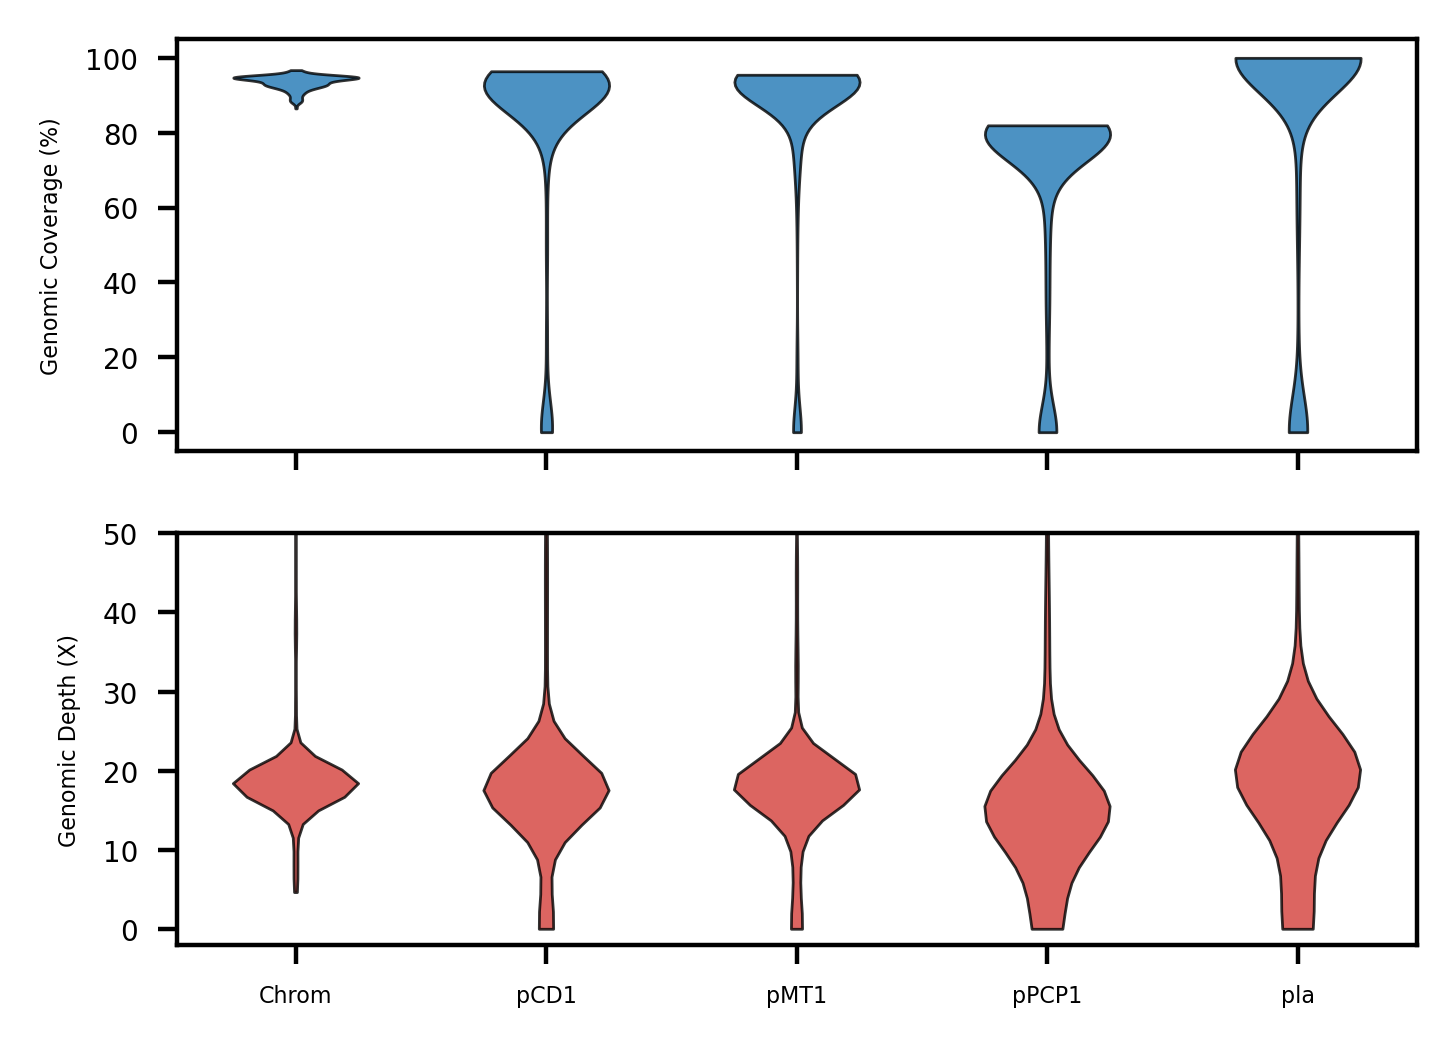

In [10]:
fig, axes = plt.subplots(2,1, dpi=dpi, figsize=(4,3), sharex=True)
covs = axes[0].violinplot(
    dataset=[locus_cov_df[col] * 100 for col in locus_cov_df.columns],
    #dataset=[cov_data[col] * 100 for col in cov_data.columns],
    #showmeans=True,
    showmedians=False,
    showextrema=False,
)  


deps = axes[1].violinplot(
    dataset=locus_dep_df, 
    #showmeans=True,
    showmedians=False,
    showextrema=False,
)    

labels = [NO_DATA_CHAR] + [locus.split("_")[0] for locus in locus_cov_df.columns if "cov" in locus]
axes[1].set_xticklabels(labels, fontsize=4)

axes[0].set_ylabel("Genomic Coverage (%)", fontsize=4)
axes[1].set_ylabel("Genomic Depth (X)", fontsize=4)
axes[1].set_ylim(-2,50)

for cov,dep in zip(covs["bodies"], deps["bodies"]):
    cov.set_linewidth(1)
    dep.set_facecolor('#D43F3A')    
    cov.set_alpha(0.8); dep.set_alpha(0.8)
    cov.set_linewidth(0.5); dep.set_linewidth(0.5)
    cov.set_edgecolor('black'); dep.set_edgecolor('black')
    
out_path = os.path.join(outdir, SCRIPT_NAME + "_summary." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
# 3. Plot Locus Coverage: Phylo

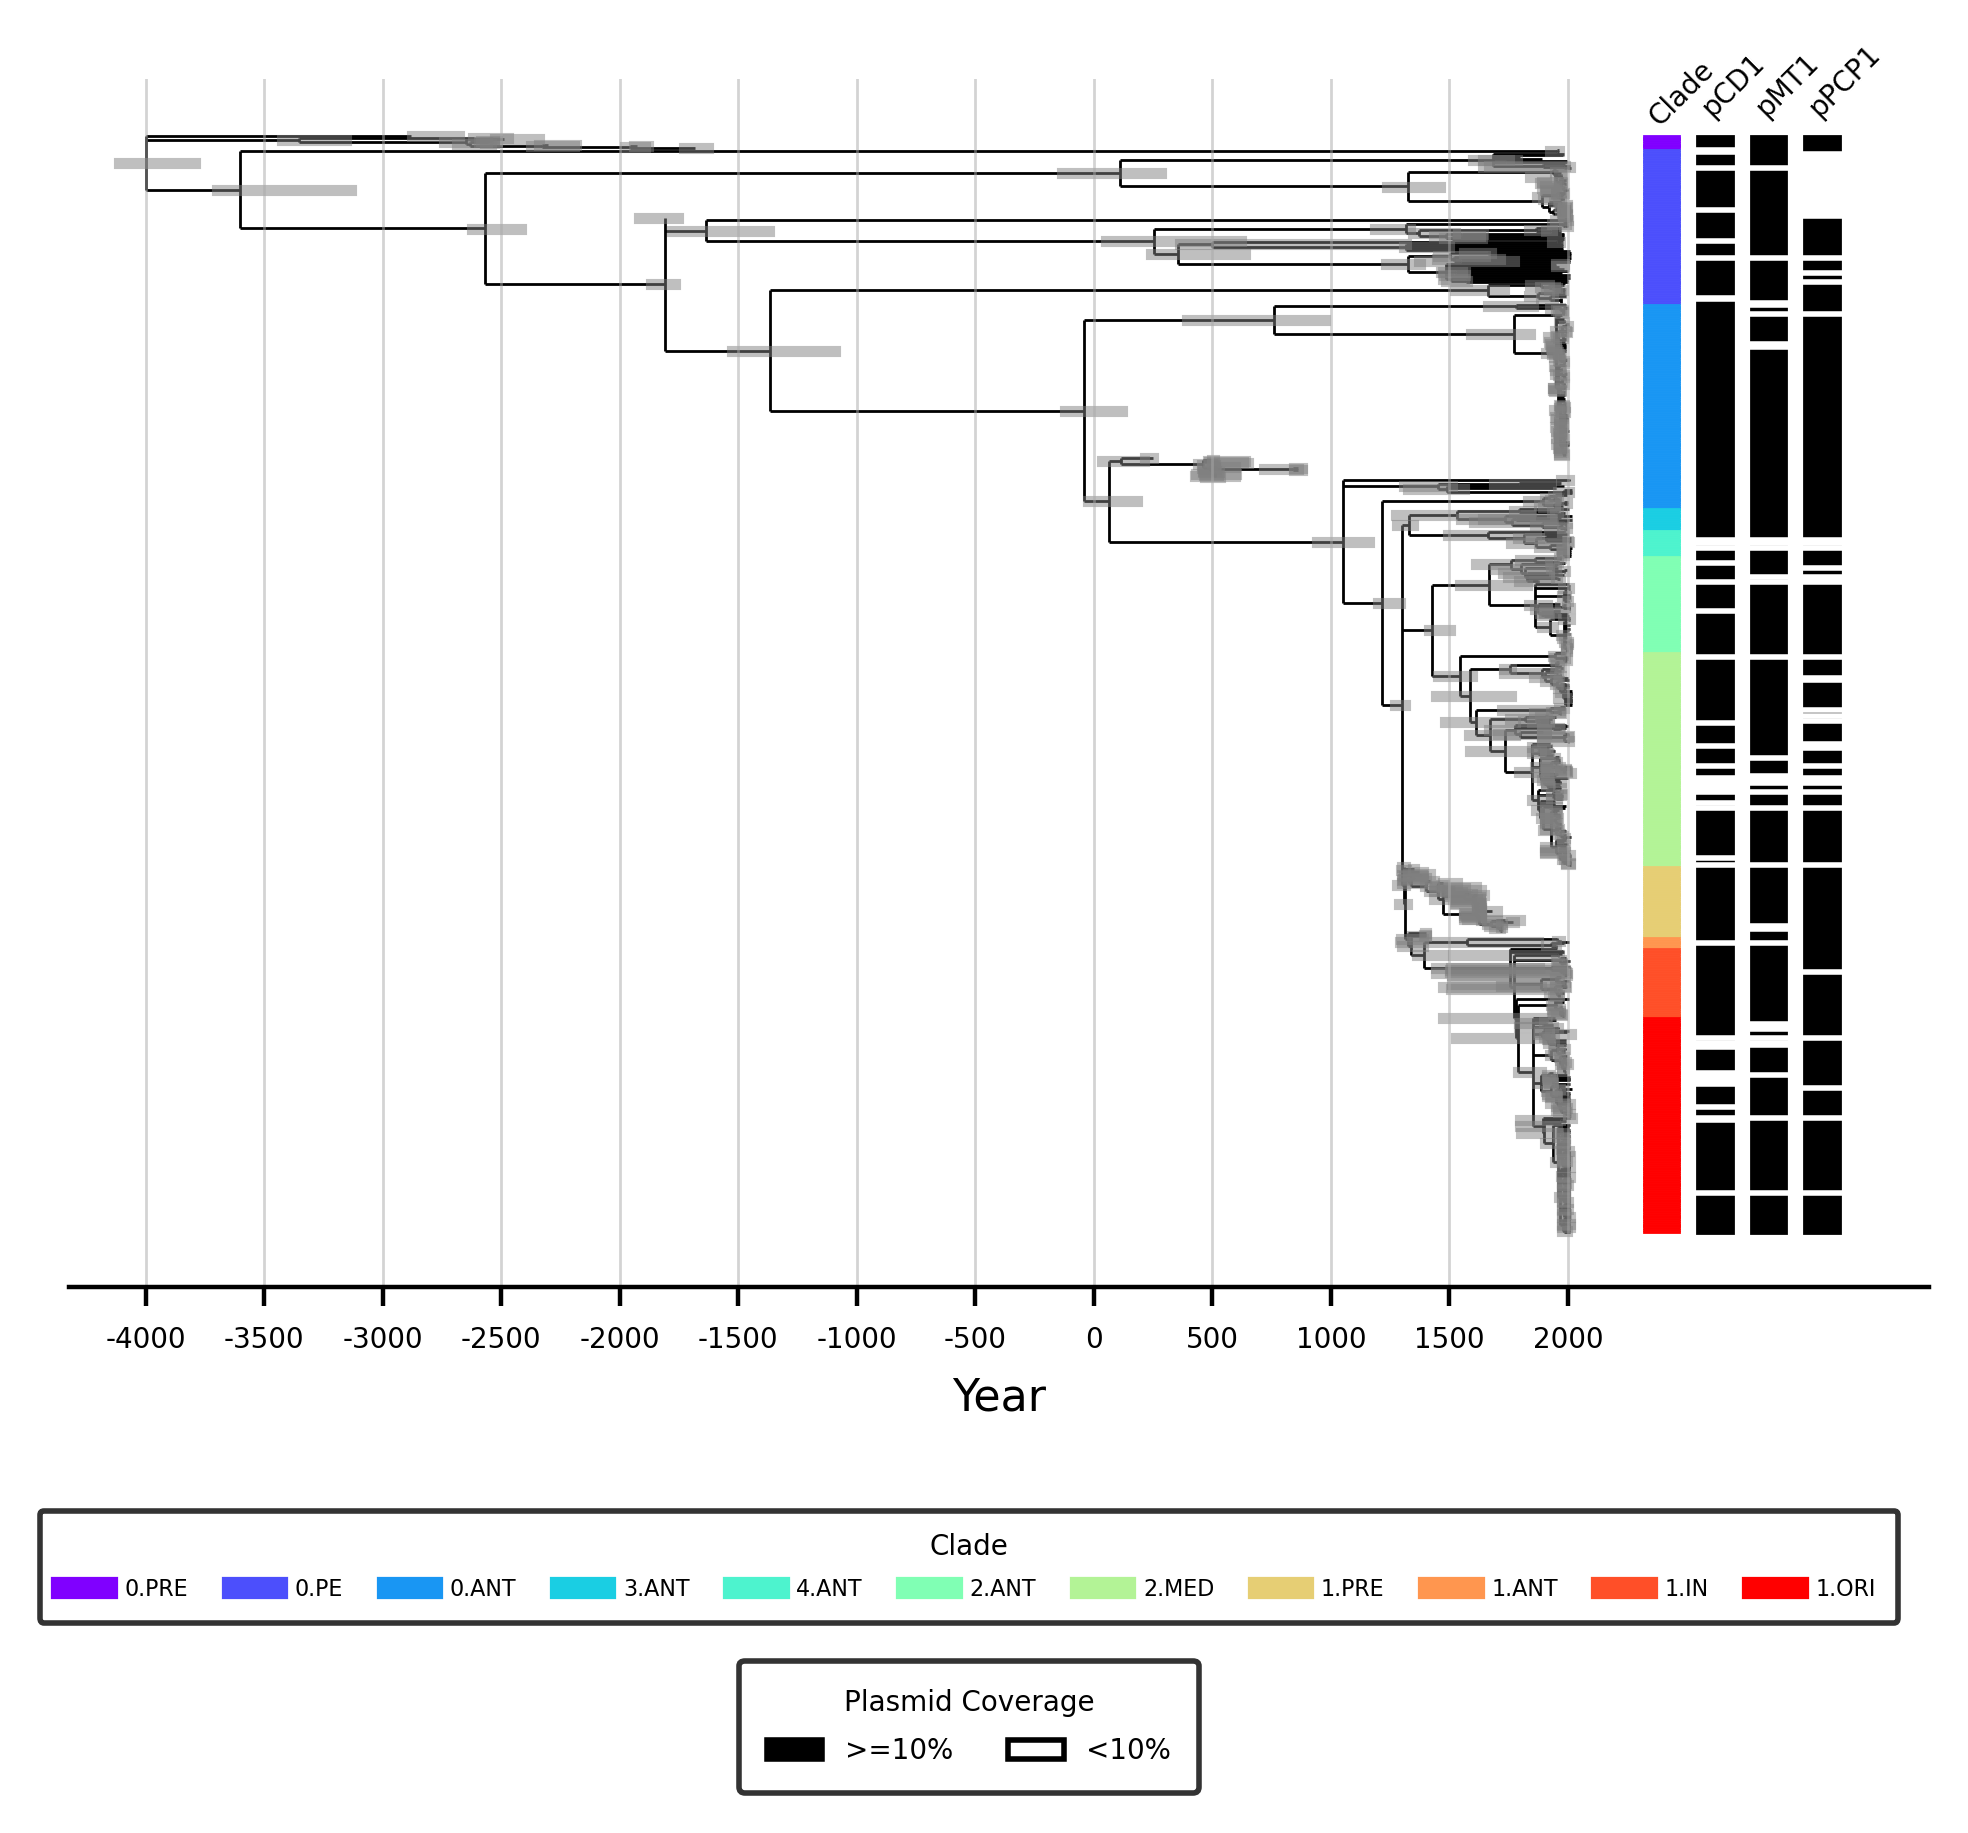

In [34]:
# Plot setup
fig, ax1 = plt.subplots(1, dpi=dpi)

# Colors Setup
attr = "Branch_Major"
attr_lower = attr.lower()
attr_colors_df = colors_df[colors_df["Attribute"] == attr_lower][["State","Color"]]
attr_colors_dict = {}
for rec in attr_colors_df.iterrows():
    state = rec[1]["State"]
    color = rec[1]["Color"]
    attr_colors_dict[state] = color

tt_copy = copy.deepcopy(tt)


# --------------------------------------------
# Phylogeny Lines
Phylo.draw(tt_copy.tree,
           axes=ax1,
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False,
          )

# Node Bars
x_min = 0
if hasattr(tt_copy.tree.root, "marginal_inverse_cdf"):
    # Need to invert the node bar units
    present_date = abs(tt_copy.tree.root.numdate - CURRENT_YEAR)
    for rec in tree_df.iterrows():
        conf_bar = rec[1]["timetree_num_date_bar"]
        bar_lower = present_date - conf_bar[0]
        bar_upper = present_date - conf_bar[1]
        y = rec[1]["timetree_coord_y"]
        ax1.plot([bar_lower, bar_upper], [y,y], alpha=0.5, c="grey", linewidth=2)
        
        # Possibly update axis x-limits
        if bar_lower < x_min:
            x_min = bar_lower

# --------------------------------------------
# Phylogeny Scatter
tip_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
#ax1.scatter(data=tip_data, x="timetree_coord_x", y="timetree_coord_y", s=0.5, c="grey")

# --------------------------------------------
# Heatmap - Attribute

# Heatmap x coordinates will stay the same
heatmap_x_buffer = max(tree_df["timetree_coord_x"]) * 0.05
heatmap_x1 = max(tree_df["timetree_coord_x"]) + heatmap_x_buffer
heatmap_x2 = heatmap_x1 + (0.5 * heatmap_x_buffer)

for rec in tip_data.iterrows():
    y = rec[1]["timetree_coord_y"]
    state = rec[1][attr]
    color = attr_colors_dict[state]
    ax1.plot([heatmap_x1, heatmap_x2], [y,y], alpha=1, c=color, linewidth=0.5)

# Label
ax1.text(x=heatmap_x1, y=-5, s="Clade", ha="left", rotation=45)

# --------------------------------------------
# Heatmap - Locus Coverage

# Labels
locus_x1 = heatmap_x1
locus_x2 = heatmap_x2        
locus_cov_df = tree_df[tree_df["pCD1_cov"] != NO_DATA_CHAR][["pCD1_cov", "pMT1_cov", "pPCP1_cov"]]


for locus in locus_cov_df.columns:
    locus_x1 = locus_x2 + (0.25 * heatmap_x_buffer)
    locus_x2 = locus_x1 + (0.5 * heatmap_x_buffer)      
    locus_name = locus.split("_")[0]
    ax1.text(x=locus_x1, y=-10, s=locus_name, ha="left", rotation=45)

# Bars

# Black Background
locus_x1 = heatmap_x1
locus_x2 = heatmap_x2 
for locus in locus_cov_df.columns:
    # Update locus coordinates
    locus_x1 = locus_x2 + (0.25 * heatmap_x_buffer)
    locus_x2 = locus_x1 + (0.5 * heatmap_x_buffer)
    rect_x = locus_x1
    rect_y = min(tree_df["timetree_coord_y"])
    rect_width = locus_x2 - locus_x1
    rect_height = max(tree_df["timetree_coord_y"])
    rect = patches.Rectangle(xy=(rect_x, rect_y), width=rect_width, height=rect_height, linewidth=0.5, edgecolor='black', facecolor="black")
    ax1.add_patch(rect)  

# White lines for absence
for rec in locus_cov_df.iterrows():   
    locus_x1 = heatmap_x1
    locus_x2 = heatmap_x2 
    sample = rec[0]
        
    for locus in locus_cov_df.columns:
        locus_x1 = locus_x2 + (0.25 * heatmap_x_buffer)
        locus_x2 = locus_x1 + (0.5 * heatmap_x_buffer)
        
        cov = locus_cov_df[locus][sample]
        y = tree_df["timetree_coord_y"][sample]
        if cov < 0.1: 
            ax1.plot([locus_x1, locus_x2], [y,y], alpha=1, c="white", linewidth=1)
"""
# --------------------------------------------
# Heatmap - pla depth

locus_x1 = locus_x2 + (0.25 * heatmap_x_buffer)
locus_x2 = locus_x1 + (0.5 * heatmap_x_buffer)

# label
ax1.text(x=locus_x1, y=-10, s="pla", ha="left", rotation=45)

dep_df = tree_df[
                   (tree_df[l + "_" + g + "_dep_ratio"] != NO_DATA_CHAR) &
                   (~tree_df["BioSampleComment"].str.contains("Assembly")) &
                   (tree_df["pPCP1_dep"] != NO_DATA_CHAR)
                   ][["pPCP1_dep", "pla_dep", "pPCP1_pla_dep_ratio"]]
dep_df = dep_df[dep_df["pPCP1_dep"] >= 10]

for rec in dep_df.sort_values(by="pPCP1_pla_dep_ratio").iterrows():
    sample = rec[0]
    val = rec[1]["pPCP1_pla_dep_ratio"]
    y = tree_df["timetree_coord_y"][sample]
    if val < (20/15):
        color = "green"
    else:
        color = "red"
    ax1.plot([locus_x1, locus_x2], [y,y], alpha=1, c=color, linewidth=1)

"""
# --------------------------------------------
# Ticks
ticks_dict = convert_timetree_ticks(tree=tt_copy.tree, step=500)
# Set the new tick locations and labels
# Leave out last one
ax1.set_xticks(ticks_dict["tick_locs"][:-1])
ax1.set_xticklabels(ticks_dict["tick_labels"][:-1])

# --------------------------------------------
# Lines
# Vertical lines for dates
for loc in ticks_dict["tick_locs"][:-1]:
    ax1.axvline(x=loc, color="darkgrey", alpha=0.5)

# --------------------------------------------
# Limits

x_buffer = math.ceil((ticks_dict["tick_locs"][-1] - ticks_dict["tick_locs"][0]) * 0.05)
y_buffer = math.ceil(len(tt_copy.tree.get_terminals()) * 0.05)

ax1.set_xlim(0 - x_buffer,)    
ax1.set_ylim(len(tt_copy.tree.get_terminals()) + y_buffer, 0 - y_buffer)
ax1.set_yticks([])    


# --------------------------------------------
# Labels
ax1.set_xlabel("Year")
ax1.set_ylabel("")

# --------------------------------------------
# Frames
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)

# -------------------------------
# Legend

legend_lines = [lines.Line2D([0], [0], color=attr_colors_dict[state], lw=4) 
                for state in attr_colors_dict]
legend_labels = [state for state in attr_colors_dict]

legend = fig.legend(legend_lines, 
           legend_labels,
           ncol=len(legend_labels),
           loc="center", 
           bbox_to_anchor=(0.5, -0.05),
           #bbox_to_anchor=(0.14,-0.13),
           frameon=True,
           borderpad=1.0,
           edgecolor="black",
           title="Clade",
           title_fontsize=SM_FONT,
           fontsize=4,
          )

locus_patches = [patches.Patch(facecolor="black", edgecolor="black",),
                 patches.Patch(facecolor="white", edgecolor="black",),]

locus_labels = [">=10%", "<10%", ]

locus_legend = fig.legend(locus_patches, 
           locus_labels,
           ncol=len(locus_labels),
           loc="center", 
           bbox_to_anchor=(0.5, -0.15),
           frameon=True,
           borderpad=1.0,
           edgecolor="black",
           title="Plasmid Coverage",
           title_fontsize=SM_FONT
           )

"""gene_patches = [patches.Patch(facecolor="green", edgecolor="black",),
                patches.Patch(facecolor="red", edgecolor="black",),
                patches.Patch(facecolor="white", edgecolor="black",),]
gene_labels = [">= Plasmid Depth", "< Plasmid Depth", "No Sequence Data"]

gene_legend = fig.legend(gene_patches, 
           gene_labels,
           ncol=len(gene_labels),
           loc="center", 
           bbox_to_anchor=(0.75, -0.15),
           frameon=True,
           borderpad=1.0,
           edgecolor="black",
           title="Gene Depth",
           title_fontsize=SM_FONT
           )
"""
# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_phylo." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
# 3. Plot Locus vs. Gene Ratio

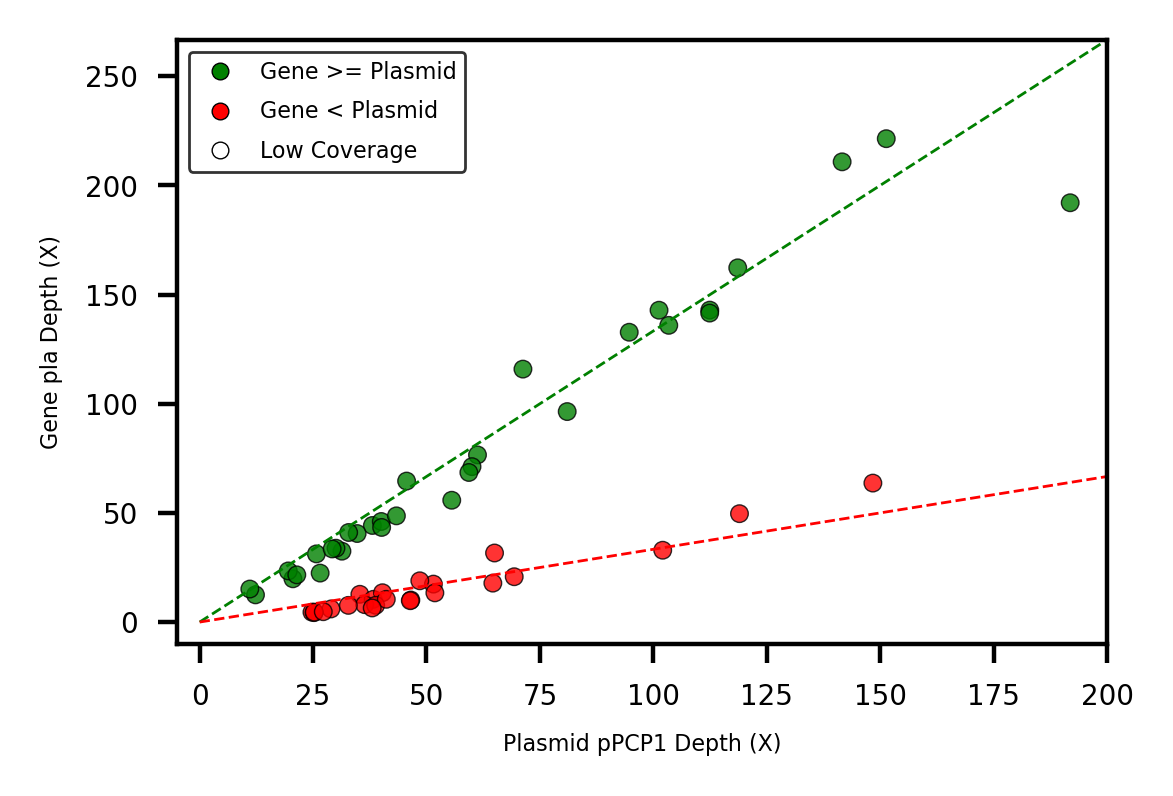

In [12]:
dep_df = tree_df[
                   (tree_df[l + "_" + g + "_dep_ratio"] != NO_DATA_CHAR) &
                   (~tree_df["BioSampleComment"].str.contains("Assembly"))
                   ][["pPCP1_dep", "pla_dep", "pPCP1_pla_dep_ratio"]]




fig, ax1 = plt.subplots(1, 1, dpi=dpi, figsize=(3,2))

colors = []
for rec in dep_df.iterrows():
    ratio = rec[1]["pPCP1_pla_dep_ratio"]
    cov = rec[1]["pPCP1_dep"]
    # If coverage is low, ratio doesn't matter
    if cov < 10:
        color = "white"
    elif ratio <= (20/15):
        color = "green"
    else:
        color = "red"
    colors.append(color)

#colors = ["red" if r > (20/15) else "green" for r,c in dep_df[["pPCP1_pla_dep_ratio","pPCP1_dep"]]]
ax1.scatter(x=dep_df["pPCP1_dep"], 
            y=dep_df["pla_dep"], 
            s=10, 
            alpha=0.8, 
            edgecolor="black", 
            linewidth=0.25, 
            color=colors
            )

x = 200
y_norm = x * (20/15)
y_low = x
ax1.plot([0,x], [0,x*(20/15)], color="green", linestyle="--")
#ax1.plot([0,175], [0,225], color="green", linestyle="--")
#ax1.plot([0,x], [0,x/3], color="red", linestyle="--")
ax1.plot([0,x], [0,x * (1/3)], color="red", linestyle="--")


ax1.set_xlabel("Plasmid pPCP1 Depth (X)",fontsize=4)
ax1.set_ylabel("Gene pla Depth (X)",fontsize=4)

ax1.set_xlim(-5,x)
ax1.set_ylim(-10,x*20/15)

#ax1.set_title("Comparison of pPCP1 Depth and pla Depth", fontsize=SM_FONT)

legend_labels = ["Gene >= Plasmid", "Gene < Plasmid", "Low Coverage"]
legend_lines = [
    lines.Line2D([], [], markeredgecolor="black", markerfacecolor='green', markeredgewidth=0.25, marker='.', linestyle='None', markersize=6,),
    lines.Line2D([], [], markeredgecolor="black", markerfacecolor='red', markeredgewidth=0.25, marker='.', linestyle='None', markersize=6,),
    lines.Line2D([], [], markeredgecolor="black", markerfacecolor='white', markeredgewidth=0.25, marker='.', linestyle='None', markersize=6,),    
               ]
"""fig.legend(legend_lines, 
           legend_labels,
           loc='upper left',
           frameon=True,
           edgecolor="black",
          )"""

legend = fig.legend(legend_lines, 
                    legend_labels, 
                    loc='center', 
                    bbox_to_anchor=(0.25, 0.79), 
                    frameon=True, 
                    fontsize=4,
                    edgecolor="black")

legend.get_frame().set_linewidth(0.5)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_pPCP1-pla-depth." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

# ? Export

## Dataframe

In [13]:
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)

## Timetrees

In [14]:
# Phyloxml
tt_copy = copy.deepcopy(tt)
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + "_timetree.xml" )
Phylo.write(tt_copy.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_timetree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_timetree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_timetree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1

## Divtrees

In [15]:
tt_copy = copy.deepcopy(tt)
# Convert to divtree
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length

# Phyloxml
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + "_divtree.xml" )
Phylo.write(tt_copy.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_divtree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_divtree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_divtree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1

## Augur JSON

In [16]:
augur_dict = augur_export(
    tree_path=out_path_nwk, 
    aln_path=aln_path, 
    tree=tt_copy.tree, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "lat", "lon"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["NODE0"])

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

{'ufboot': 100.0, 'scf': 'NA', 'branch_length': 0.0, 'strain': 'NA', 'date': 'NA', 'datebp': 'NA', 'country': 'Russia', 'province': 'Krasnoyarsk Krai', 'biovar': 'NA', 'branch_major': '0.PRE', 'branch_minor': '0.PRE2', 'biosample': 'NA', 'biosamplecomment': 'NA', 'branch_number': '0', 'rate': 9.263553689093914e-09, 'rate_fold_change': 1.0, 'mutation_length': 2.148814885614286e-07, 'raw_date': '-4000-09-21', 'num_date': -3999.2774811378754, 'num_date_confidence': [-4114.0959399021, -3791.54718956593], 'num_date_bar': '6135.0959399021:5812.54718956593', 'clock_length': 0.1, 'reg_x': -3999.2774811378754, 'reg_y': 0.0, 'reg_bad': 'False', 'branch_number_confidence': {'0': 0.9999999960608318}, 'branch_number_entropy': 8.555654203704375e-08, 'branch_major_confidence': {'0.PRE': 0.9987313440840127}, 'branch_major_entropy': 0.009770689956452923, 'branch_minor_confidence': {'0.PRE2': 0.3924363593063639}, 'branch_minor_entropy': 1.3290705422536453, 'country_confidence': {'Russia': 0.992420088405

## Auspice JSON

In [17]:
auspice_dict = auspice_export(
    tree=tt_copy.tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlon_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")

<class 'dict'>
Validating schema of '../../config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '../../results/locus_coverage/all/locus_coverage_auspice.json'...
Validating that the JSON is internally consistent...
Validation of '../../results/locus_coverage/all/locus_coverage_auspice.json' succeeded.
Validation successful for local JSON.
Validating produced JSON
Validating schema of '../../auspice/plague-phylogeography_locus-coverage.json'...
Validating that the JSON is internally consistent...
Validation of '../../auspice/plague-phylogeography_locus-coverage.json' succeeded.
Validation successful for remote JSON.
